This is a notebook version of the toy example for the NUTS (no u-turn) sampler. It does exactly the same, but in notebook form.

In [1]:
from OLE.theory import Theory
from OLE.likelihood import Likelihood
import jax.numpy as jnp
import matplotlib.pyplot as plt

import numpy as np
try:
    import corner
    corner_available = True
except:
    corner_available = False

First we define our "theory code", here a simple function, computing a y-vector and a y-scalar from the input parameters x1, x2, and x3

In a real analysis, the role of the theory code would be played by e.g. a python wrapper for CLASS or CAMB.

In [2]:
class my_theory(Theory):

    def initialize(self, **kwargs):
        super().initialize(**kwargs)   

        # input parameters of the theory
        self.requirements = ['x1', 'x2', 'x3']

    def compute(self, state):
        # Compute the observable for the given parameters.

        # parameters x1,x2,x3
        # observables y_array, y_scalar
        self.parameters = ['x1', 'x2', 'x3']

        state['quantities']['y_array'] = jnp.array([0.3*jnp.sin(2.*state['parameters']['x1'][0])+state['parameters']['x1'][0], 0.5*state['parameters']['x3'][0]+state['parameters']['x2'][0], state['parameters']['x3'][0]])
        state['quantities']['y_scalar'] = jnp.array([jnp.sum(state['quantities']['y_array'])])
        return state

We now define our likelihood code, used to determine the Bayesian likelihood of a given parameter realisation (in our example, x1, x2, x3).

Here, it is a simple function of th quantities y_array and y_scalar, but often it would involve comparing the output of the theory code to observational data.

In [3]:
class my_likelihood(Likelihood):

    def initialize(self, **kwargs):
        super().initialize(**kwargs)  

        self.requirements = {'y_array': None, 'y_scalar': None} 
    

    def loglike(self, state):
        # Compute the loglikelihood for the given parameters.
        loglike = -10.*jnp.sum((state['quantities']['y_array'])**2) - 10.*(state['quantities']['y_scalar']-0.5)**2 - state['quantities']['y_array'][0]*state['quantities']['y_array'][1]
        return loglike

Now we declare the instances we require and their settings. OLE wants a dictionary of likelihoods, since this makes it easy to perform inference using multiple datasets simultaneously, e.g. a CMB+BAO analysis.

In [4]:
# First, we define an instance of our theory code, 
# and a dictionary of the settings we want to pass to it.
# In a real analysis, this could be precision settings, or flags for
# which parametrization to use for reionization.
my_theory = my_theory()
theory_settings = {}


# Now we define our dictionary of likelihoods, again, for a likelihood
# more advanced than our toy model, we could pass settings for this run
my_likelihood_collection = {'toy':my_likelihood()}
my_likelihood_collection_settings = {'toy': {}}

# We also pass settings for OLE's sampler, in this case just where to
# output the results.
sampling_settings = {
    'output_directory': './toy_notebook',
}

# Finally, we pass settings to the emulator part of OLE
emulator_settings = {
    'logfile': './toy_notebook/log.txt',
    'min_variance_per_bin': 1e-6,
    'cache_file': './toy_notebook/cache.pkl',
    'dimensionality': 3,

    'test_emulator': True,
}

We now declare our parameters, these are the ones we will draw samples for to put into the theory code. We give priors on these, as well as reference values ('mean'), expected width ('std'), and a scaling of the step size ('proposal')

In [5]:
my_parameters = {'x1': {'prior': {'min': 0.0, 'max': 3.0, 'type': 'uniform'},
                        'ref': {'mean': 0.2, 'std': 0.1},
                        'proposal': 1.0,},
                    'x2': {'prior': {'min': 0.0, 'max': 3.0, 'type': 'uniform'},
                        'ref': {'mean': 0.2, 'std': 0.1},
                        'proposal': 1.0,},
                    'x3': {'prior': {'min': 0.0, 'max': 3.0, 'type': 'uniform'},
                        'ref': {'mean': 0.2, 'std': 0.1},
                        'proposal': 1.0,},
                           } 

Finally, before we initialise and start sampling, we declare our instance if OLE's NUTS sampler

In [6]:
# load sampler 
from OLE.sampler import NUTSSampler
my_sampler = NUTSSampler()

We now initialize the sampler we declared, passing it our theory, likelihood, and the various settings.

In [7]:
# initialize sampler
my_sampler.initialize(theory=my_theory, 
                      likelihood_collection=my_likelihood_collection, 
                      parameters=my_parameters, 
                      emulator_settings=emulator_settings, 
                      likelihood_collection_settings=my_likelihood_collection_settings, 
                      theory_settings=theory_settings, 
                      sampling_settings=sampling_settings)

2024-10-01 16:29:12,727 - Emulator - INFO - Emulator initialized
INFO:Emulator:Emulator initialized
2024-10-01 16:29:13,083 - Emulator - INFO - Create emulator for y_array
INFO:Emulator:Create emulator for y_array
2024-10-01 16:29:13,084 - Emulator - INFO - Create emulator for y_scalar
INFO:Emulator:Create emulator for y_scalar


Finally, with the sampler initialized, we can run our MCMC chains. For the purpose of this example, we choose a relatively modest 1000 steps. This is the most time consuming part of this example, and can take several minutes.

The progress can be followed in the output.

In [8]:
# Note the total run steps are   (nsteps * nwalkers * MPI_size)
n_steps = 1000
my_sampler.run_mcmc(n_steps)

2024-10-01 16:33:26,072 - NUTSSampler - INFO - Current sampler call: 0
INFO:NUTSSampler:Current sampler call: 0
2024-10-01 16:33:26,151 - DataCache - INFO - Cache size: 2/1000
INFO:DataCache:Cache size: 2/1000
2024-10-01 16:33:26,179 - DataCache - INFO - Cache size: 3/1000
INFO:DataCache:Cache size: 3/1000
2024-10-01 16:33:27,088 - NUTSSampler - INFO - Current sampler call: 100
INFO:NUTSSampler:Current sampler call: 100
2024-10-01 16:33:27,342 - DataCache - INFO - Cache size: 4/1000
INFO:DataCache:Cache size: 4/1000
2024-10-01 16:33:27,413 - DataCache - INFO - Cache size: 5/1000
INFO:DataCache:Cache size: 5/1000
2024-10-01 16:33:27,614 - DataCache - INFO - Cache size: 6/1000
INFO:DataCache:Cache size: 6/1000
2024-10-01 16:33:27,888 - DataCache - INFO - Cache size: 7/1000
INFO:DataCache:Cache size: 7/1000
2024-10-01 16:33:27,975 - NUTSSampler - INFO - Current sampler call: 200
INFO:NUTSSampler:Current sampler call: 200
2024-10-01 16:33:28,273 - DataCache - INFO - Cache size: 7/1000
INFO

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

2024-10-01 16:34:03,359 - NUTSSampler - INFO - Starting minimization after first emulator training to find bestfit and covmat.
INFO:NUTSSampler:Starting minimization after first emulator training to find bestfit and covmat.
  NIT   NF   F                       GTG
    0    1  7.345604465836063E+00   9.94653071E+02
tnc: fscale = 0.0105692
    1    3  4.124582959140684E+00   1.60865582E+01
    2    5  3.939904641548544E+00   1.37165801E-01
tnc: fscale = 0.900028
tnc: |fn-fn-1] = 0.00114416 -> convergence
    3    7  3.938760481434273E+00   1.72899071E-01
tnc: Converged (|f_n-f_(n-1)| ~= 0)
2024-10-01 16:34:08,336 - NUTSSampler - INFO - Minimization after first emulator training finds:
INFO:NUTSSampler:Minimization after first emulator training finds:
2024-10-01 16:34:08,337 - NUTSSampler - INFO - Bestfit: 
INFO:NUTSSampler:Bestfit: 
2024-10-01 16:34:08,338 - NUTSSampler - INFO - x1: 0.07418484189076074 x2: 0.04177294030566642 x3: 0.13811261287589988
INFO:NUTSSampler:x1: 0.074184841890760

Finally, the chain can be obtained from the sampler object, and if installed,the corner package can be used to easily create a cornerplot.

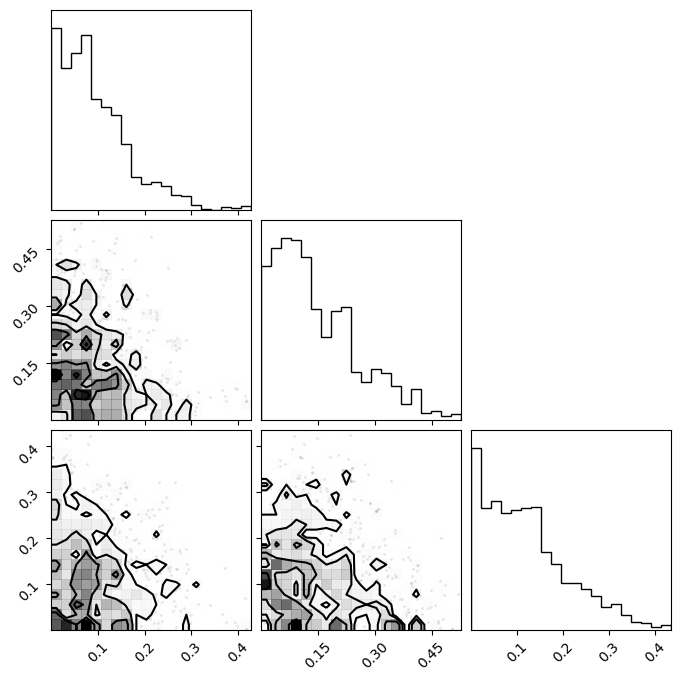

In [9]:
chain = my_sampler.chain

if corner_available:
    fig = corner.corner(np.array(chain))
    plt.savefig('toy_notebook/corner_nuts.png')